# Configure enviroment

In [0]:
from google.colab import drive
drive.mount('drive', force_remount=True)

# Imports

In [0]:
import math
import itertools
import re
import os
import imageio
import shutil
import numpy as np
import pandas as pd
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tqdm import tqdm
import random

# Settings

In [0]:
# Begin Settings -------------------------|

# If set True, it shows data informations in the output of the program
LOG = True

# Random seed to get a better reproductibility
np.random.seed(1937)

# Resolution of the images
RES = 64

# Size of the test fold
TEST_SIZE = 50

# ------------------------------data strategy settings------------------------------

# Number of slices for each nodule
SLICES = 5

# Strategy used for normalization - it can be 'first' or 'balanced'
STRATEGY = 'first'

'''If set True, it will repeat slices when the number of slices of a nodule is less than SLICES. 
    If set False, the normalization will be filling with black images in the end'''
REPEAT = False

prefix = "/content/drive/My Drive/Pesquisa - Dicom images/data"

# It makes the name for the folder where the numpies will be stored
data_folder = prefix + "/clean_nps/data-" + str(SLICES) + "-" + str(STRATEGY)
if (REPEAT):
    data_folder += "-repeat"

# Important folders ---------------------------------------------------------

base_dir = prefix + "/images/solid-nodules-with-attributes"

# Folder for the benigno image files
ben_dir = base_dir + "/benigno"

# Folder for the maligno image files
mal_dir = base_dir + "/maligno"

# Path for the features file
features_path = prefix + "/features/solidNodules.csv"

# Balanced Strategy
Normalizes the nodule slices number:
    - A nodule with less than n slices is completed with black slices
    - A nodule with more than n slices have its first and last one selected, plus the 1 + (n-1/5)*k, where k = {1, 2, 3, 4}

In [0]:
def normalize_balanced(nodules, n_slices, repeat=False):
    normalized_slices = []

    for nodule in nodules:
        new_nodule = []
        
        # If repeat is set True, repeat slices
        if repeat:
            times = math.ceil(n_slices/len(nodule))
            nodule = list(itertools.chain.from_iterable(itertools.repeat(x, times) for x in nodule))

        if len(nodule) <= n_slices:
                for slice in nodule:
                    new_nodule.append(slice)
                for _ in range(n_slices - len(nodule)):
                    new_nodule.append(np.zeros((RES, RES)))
        elif len(nodule) > n_slices:
            new_nodule.append(nodule[0])
            for k in range(1, n_slices-1):
                new_nodule.append(nodule[round(1 + ((len(nodule) - 1) / (n_slices-1)) * k)])
            new_nodule.append(nodule[-1])
        normalized_slices.append(new_nodule)
    return normalized_slices

# Get first slices Strategy
    Normalizes the nodule slices number:
    - A nodule with less than n slices is completed with black slices
    - A nodule with more than n slices have its n first slices selected

In [0]:
def normalize_first(nodules, n_slices, repeat=False):
    normalized_slices = []

    for nodule in nodules:
        new_nodule = []

        if repeat:
            times = math.ceil(n_slices/len(nodule))
            nodule = list(itertools.chain.from_iterable(itertools.repeat(x, times) for x in nodule))

        if len(nodule) <= n_slices:
                for slice in nodule:
                    new_nodule.append(slice)
                for i in range(n_slices - len(nodule)):
                    new_nodule.append(np.zeros((RES, RES)))
        elif len(nodule) > n_slices:
            for i in range(0, n_slices):
                new_nodule.append(nodule[i])
        normalized_slices.append(new_nodule)
    return normalized_slices

# Read images and features, connecting each nodule to its features
Reads the image files and a .csv with the features of each nodule
    - path (string): path to the nodules folders
    - path_features (string): path to the features .csv
    - list: list of nodules with slices as Numpy Arrays
    - features: list of features corresponding to the nodules on list

In [0]:
def read_images(path, path_features):
    df = pd.read_csv(path_features)
    allFeatures = df.values

    list        = []
    features    = []

    for _,dirs,_ in os.walk(path):
        for dirname in sorted(dirs, key=str.lower):
            for _,subdirs,_ in os.walk(path + "/" + dirname):
                for subdirname in sorted(subdirs, key=str.lower):
                    for root2,_,files2 in os.walk(path + "/" + dirname + "/" + subdirname):
                        slices      = []
                        files2[:]   = [re.findall('\\d+', x)[0] for x in files2]

                        axis            = 0 # To get the Rows indices
                        examColumn      = 0 # Column of the csv where the exam code is
                        noduleColumn    = 1 # Column of the csv where the nodule code is

                        # index of the rows that have the exam id equal to the exam id of the current nodule
                        indExam = np.where(allFeatures[:,examColumn] == dirname)[axis]

                        # index of the rows that have the nodule id equal to the id of the current nodule
                        indNodule = np.where(allFeatures[:,noduleColumn] == subdirname)[axis]

                        # Intersect the two arrays, which results in the row for the features 
                        # of the current nodule
                        i = np.intersect1d(indExam,indNodule)

                        # A list is returned, but there's just one value, so I used its index
                        index   = 0
                        exam    = allFeatures[i, examColumn][index]
                        nodule  = allFeatures[i, noduleColumn][index]

                        '''Verify if there's more than one index for each nodule
                        and if there's divergence between the nodule image file location and the
                        csv values'''

                        if((len(i) > 1) or (str(exam) != str(dirname)) or (str(nodule) != str(subdirname))):
                            print("Features error!")
                        else:
                            '''Transform the list of index with just one value in a
                            primitive value to use as index to save the features values'''
                            i = i[0]

                        for f in sorted(files2, key=float):
                            img = imageio.imread(root2 + "/" + f + ".png", as_gray=True)
                            slices.append(img)

                        list.append(slices)
                        features.append(allFeatures[i,2:74].tolist())

    return list, features

# Nodule(s) plot(s)
Function to plot a sequence of images. 
    - nodules: a numpy of nodule images
    - ind_nodules: list of indices to referenciate nodules in the 'nodules' numpy
    - ind_slices: list of indices to referenciate the slices of each nodule to be plotted

In [0]:
'''Function to plot a sequence of images. 
    nodules: a numpy of nodule images
    ind_nodules: list of indices to referenciate nodules in the 'nodules' numpy
    ind_slices: list of indices to referenciate the slices of each nodule to be plotted'''
def plot_nodule(nodules, ind_nodules, ind_slices):
    
    rows = len(ind_nodules)
    columns = len(ind_slices)

    _, axarr = plt.subplots(rows,columns)
    ind = 0

    for r, i in enumerate(ind_nodules):
        for c, j in enumerate(ind_slices):
            nod = nodules[i, :, :, j, 0]
            if (rows != 1 and columns != 1):
                axarr[r,c].imshow(nod, cmap='gray')
                axarr[r,c].set_title('Nodule - ' + str(i) + ' - Slice - ' + str(j))
            else:
                axarr[ind].imshow(nod, cmap='gray')
                axarr[ind].set_title('Nodule - ' + str(i) + ' - Slice - ' + str(j))
                ind += 1
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()

# Verify if the features are OK

In [0]:
def verify_features(features, step):
    index = np.random.randint(0, len(features) - step - 1)
    
    if (features[index].all() == features[index + step].all()):
        return "     Features repeat - OK"
    else:
        return "     Features repeat - FAIL"

# Data augmentation
Rotates a list of images n times.
        - 'rotated' is a list that will contain all nodule images (originals and the results of the rotations)
        - 'aug_feat' is a list that will contain all nodule features (repeated the same amount as the images get rotated)

In [0]:
def rotate_slices(nodules, features, times, mode='constant'):
    rotated = nodules
    aug_feat = features
    angle = 360/times
    
    '''Make rotations (n - 1) times, where n is equal to 'times' parameter. 
        If it was n times, it would repeat the same image one more time (360 degree)'''
    for i in range(1, times):
        temp        = rotate(input=nodules, angle=i*angle, axes=(1, 2), reshape=False, mode=mode)
        rotated     = np.concatenate([rotated, temp])
        aug_feat    = np.concatenate([aug_feat, features])

    return rotated, aug_feat

# Script to read and save data on numpy files

Begin > 
Changind shape > 
     Ben as a list:  615
     Mal as a list:  267
     Ben as a numpy:  (615, 5, 64, 64, 1)
     Mal as a numpy:  (267, 5, 64, 64, 1)

Swaping axes > 
     Ben new shape:  (615, 64, 64, 5, 1)
     Mal new shape:  (267, 64, 64, 5, 1)

Separating Train and Test > 
     Ben train:  (565, 64, 64, 5, 1)
     Ben test:  (50, 64, 64, 5, 1)

     Ben features train:  (565, 72)
     Ben features test:  (50, 72)

     Mal train:  (217, 64, 64, 5, 1)
     Mal test:  (50, 64, 64, 5, 1)

     Mal features train:  (217, 72)
     Mal features test:  (50, 72)

Data augmentation > 
     Features repeat - OK


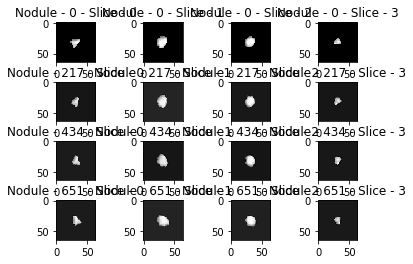

     Ben train:  (2825, 64, 64, 5, 1)
     Ben features train:  (2825, 72)

     Mal train:  (2821, 64, 64, 5, 1)
     Mal features train:  (2821, 72)

Concatenating Ben and Mal > 
     X_train:  (5646, 64, 64, 5, 1)
     f_train:  (5646, 72)

     X_test:  (100, 64, 64, 5, 1)
     f_test:  (100, 72)

Generating labels and saving numpies on disk > 
Finished!


In [24]:
if __name__ == "__main__":

    print("Begin > ")

    ben, f_ben = read_images(path=ben_dir, path_features=features_path)
    mal, f_mal = read_images(path=mal_dir, path_features=features_path)

    if (STRATEGY == 'first'):
        ben = normalize_first(nodules=ben, n_slices=SLICES, repeat=REPEAT)
        mal = normalize_first(nodules=mal, n_slices=SLICES, repeat=REPEAT)
    else:
        ben = normalize_balanced(nodules=ben, n_slices=SLICES, repeat=REPEAT)
        mal = normalize_balanced(nodules=mal, n_slices=SLICES, repeat=REPEAT)

    if LOG:
        print("Changind shape > ")
        print("     Ben as a list: ", len(ben))
        print("     Mal as a list: ", len(mal))

    ben = np.concatenate(ben).reshape(len(ben), SLICES, RES, RES, 1)
    mal = np.concatenate(mal).reshape(len(mal), SLICES, RES, RES, 1)
    
    if LOG:
        print("     Ben as a numpy: ", ben.shape)
        print("     Mal as a numpy: ", mal.shape)
        print()
        print("Swaping axes > ")

    ben = np.moveaxis(ben, 1, 3)
    mal = np.moveaxis(mal, 1, 3)

    if LOG:
        print("     Ben new shape: ", ben.shape)
        print("     Mal new shape: ", mal.shape)
        print()
        print("Separating Train and Test > ")

    ben_test_indices = np.random.choice(len(ben), TEST_SIZE, replace=False)
    mal_test_indices = np.random.choice(len(mal), TEST_SIZE, replace=False)

    ben_test = np.array([ben[i] for i in ben_test_indices])
    f_ben_test = np.array([f_ben[i] for i in ben_test_indices])

    mal_test = np.array([mal[i] for i in mal_test_indices])
    f_mal_test = np.array([f_mal[i] for i in mal_test_indices])

    ben_train = np.delete(ben, ben_test_indices, axis=0)
    f_ben_train = np.delete(f_ben, ben_test_indices, axis=0)

    mal_train = np.delete(mal, mal_test_indices, axis=0)
    f_mal_train = np.delete(f_mal, mal_test_indices, axis=0)

    # Clean memory
    del(ben, f_ben, mal, f_mal, ben_dir, mal_dir, features_path, ben_test_indices, mal_test_indices)

    if LOG:
        print("     Ben train: ", ben_train.shape)
        print("     Ben test: ", ben_test.shape)
        print()
        print("     Ben features train: ", f_ben_train.shape)
        print("     Ben features test: ", f_ben_test.shape)
        print()
        print("     Mal train: ", mal_train.shape)
        print("     Mal test: ", mal_test.shape)
        print()
        print("     Mal features train: ", f_mal_train.shape)
        print("     Mal features test: ", f_mal_test.shape)
        print()
        print("Data augmentation > ")

    ben_train, f_ben_train = rotate_slices(nodules=ben_train, features=f_ben_train, times=5)
    mal_train, f_mal_train = rotate_slices(nodules=mal_train, features=f_mal_train, times=13)
    
    if LOG:
        print(verify_features(features=f_mal_train, step=217))

        plot_nodule(nodules=mal_train, ind_nodules=[0, 217, 434, 651], ind_slices=[0, 1, 2, 3])
        
        print("     Ben train: ", ben_train.shape)
        print("     Ben features train: ", f_ben_train.shape)
        print()
        print("     Mal train: ", mal_train.shape)
        print("     Mal features train: ", f_mal_train.shape)
        print()
        print("Concatenating Ben and Mal > ")

    X_train = np.concatenate([ben_train, mal_train])
    f_train = np.concatenate([f_ben_train, f_mal_train])

    X_test  = np.concatenate([ben_test, mal_test])
    f_test  = np.concatenate([f_ben_test, f_mal_test])

    if LOG:
        print("     X_train: ", X_train.shape)
        print("     f_train: ", f_train.shape)
        print()
        print("     X_test: ", X_test.shape)
        print("     f_test: ", f_test.shape)

        print()
        print("Generating labels and saving numpies on disk > ")
    
    train_labels = len(ben_train) * [0] + len(mal_train) * [1]
    Y_train = np.array(train_labels)

    test_labels = len(ben_test) * [0] + len(mal_test) * [1]
    Y_test = np.array(test_labels)
    
    shutil.rmtree(data_folder, ignore_errors=True)
    os.mkdir(data_folder)

    np.save(data_folder + "/f_train.npy", f_train)
    np.save(data_folder + "/f_test.npy", f_test)
    np.save(data_folder + "/X_train.npy", X_train)
    np.save(data_folder + "/X_test.npy", X_test)
    np.save(data_folder + "/Y_train.npy", Y_train)
    np.save(data_folder + "/Y_test.npy", Y_test)
    
    print("Finished!")